In [1]:
import os
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.autograd import Variable
from torch.utils.data import sampler
import torch.nn.functional as F


from skimage import io, transform

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20.0, 16.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
%matplotlib inline

import timeit, random
import json, cv2
import show

%load_ext autoreload
%autoreload 2

# Ignore warnings
# import warnings
# warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [2]:
torch.cuda.is_available()

True

In [3]:
# Dataset class for memory efficient data processing 
class HandGestureDataset(torch.utils.data.Dataset):
    """ Hand Gesture Dataset """

    def __init__(self, root_dir, names, transform=False):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.joints = json.load(open(self.root_dir+"scaled_annotations.json","r"))
        self.names = names
        self.transform = transform

    def __len__(self):
        return len(self.names)

    def __getitem__(self, idx):
        idx = np.random.randint(0, len(self.names))
        name = self.names[idx]
        
        x = cv2.imread("Dataset/ColoredProcessedImages/" + self.names[idx] + ".png")
        
        temp = [0]*42
        for i, (u,v) in enumerate(self.joints[name]):
            temp[i*2]     = u
            temp[i*2 + 1] = v
        
        y = np.array(temp)
        
#         x = np.reshape(x.data, (3,128,128))
#         print(x.size)

        if self.transform:
            sample = self.hog(x)

        return name, x, y
    
    def substract_mean(self, x):
        x = x.astype(np.float64) - np.mean(x.astype(np.float64))
        return sample
    
    def hog(self, x):
#         x = cv2.Laplacian(x, cv2.CV_64F)
        x = cv2.Sobel(x, cv2.CV_64F, 1, 0, ksize=5)
#         x = cv2.Sobel(x, cv2.CV_64F, 0, 1, ksize=5)
        return sample

In [4]:
joints = json.load(open("Dataset/scaled_annotations.json","r"))
names = names = list(joints.keys())
data = HandGestureDataset("Dataset/", names[:10000], transform=False)
dataloader = torch.utils.data.DataLoader(data, batch_size=10, shuffle=True, num_workers=4)

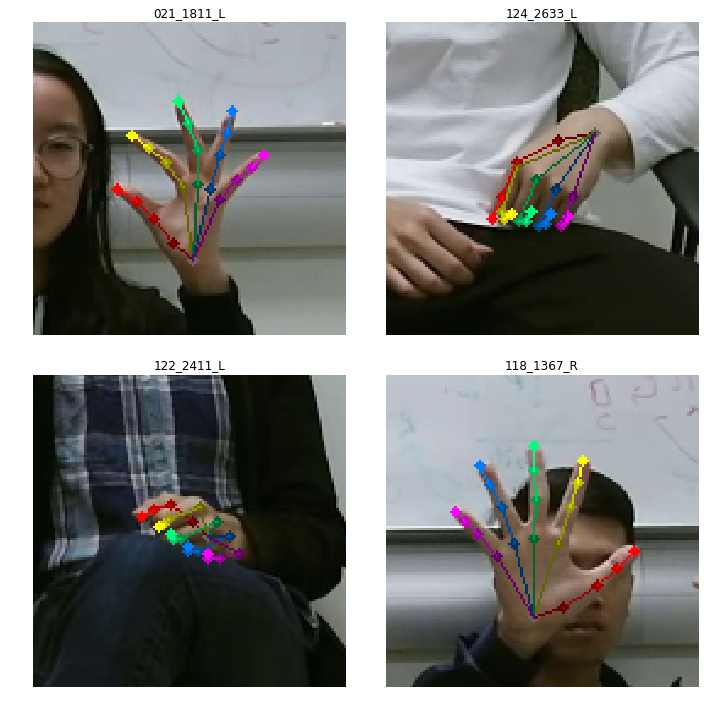

In [5]:
num = 4
fix, ax = plt.subplots(2, 2, figsize=(10, 10))
ax = [a for b in ax for a in b] # wooooo


for i in range(len(data)):
    name, x, y = data[i]
    y = np.array(y.data, dtype=int).reshape(21,2)
    
    plt.tight_layout()
    ax[i].set_title(name)
    ax[i].axis('off')
    
    
    canvas = show.draw_hand(x, y)
    
    ax[i].imshow(canvas) 

    if i == num-1:
        plt.show()
        break

In [6]:
def check_accuracy(model, loader):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    for x, y in loader:
        x_var = Variable(x.type(gpu_dtype), volatile=True)

        scores = model(x_var)
        _, preds = scores.data.cpu().max(1)
        num_correct += (preds == y).sum()
        num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

In [7]:
def train(model, loss_fn, optimizer, loader_train, loader_val=None, num_epochs=1):
    loss_history = []
    train_acc = []
    val_acc = []
    
    for epoch in range(num_epochs):
        
        print('Starting epoch %d / %d' % (epoch + 1, num_epochs))
        model.train()
        for t, (name, x, y) in enumerate(loader_train):
            x_var = Variable(x.type(gpu_dtype))
            N, C, H, W = x_var.size() # W is C
            x_var =  x_var.view(N, W, C, H)
            y_var = Variable(y.type(gpu_dtype))#.long())

            scores = model(x_var)
            
            if t == 0:
                print("scores: {}".format(scores[:10]))
                print("x_var: {}".format(x_var[:10]))
            
            loss = loss_fn(scores, y_var)
            loss_history.append(float(loss))
            
            if (t + 1) % print_every == 0:
                print('t = %d, loss = %.4f' % (t + 1, loss.data[0]))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
#         model.eval()
        
#         for x, y in loader_train:
#             x_var = Variable(x.type(gpu_dtype), volatile=True)

#             scores = model(x_var)
#             _, preds = scores.data.cpu().max(1)
#             num_correct += (preds == y).sum()
#             num_samples += preds.size(0)
#         train_acc.append(float(num_correct) / num_samples)
        
#         for x, y in loader_val:
#             x_var = Variable(x.type(gpu_dtype), volatile=True)

#             scores = model(x_var)
#             _, preds = scores.data.cpu().max(1)
#             num_correct += (preds == y).sum()
#             num_samples += preds.size(0)
#         val_acc.append(float(num_correct) / num_samples)
        
    plt.subplot(1, 1, 1)
    plt.title('Training loss')
    plt.plot(loss_history, 'o', alpha=.05)
    plt.xlabel('Iteration')

#     plt.subplot(2, 1, 2)
#     plt.title('Accuracy')
#     plt.plot(solver.train_acc_history, '-o', label='train')
#     plt.plot(solver.val_acc_history, '-o', label='val')
#     plt.plot([0.7] * len(solver.val_acc_history), 'k--')
#     plt.xlabel('Epoch')
#     plt.legend(loc='lower right')
    plt.gcf().set_size_inches(15, 12)
    plt.show()

Starting epoch 1 / 3
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
scores: tensor([[ 0.0000,  0.0358,  0.0342,  0.0000,  0.1452,  0.0358,  0.0629,
          0.0000,  0.0001,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0363,  0.0000,  0.0571,  0.0180,  0.0000,  0.0000,
          0.0757,  0.0849,  0.0000,  0.0301,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0298,  0.0059,  0.0251,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0748,  0.0000,  0.0000,  0.0118,  0.0560,  0.0193],
        [ 0.0213,  0.0000,  0.0021,  0.0000,  0.0826,  0.0156,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0335,  0.0000,  0.0000,  0.0000,  0.0000,  0.0635,
          0.0364, 

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

/home/christian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


t = 10, loss = 2917870763652415488.0000
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.S

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
t = 40, loss = 3891.4570
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
t = 120, loss = 4197.1094
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
t = 260, loss = 4205.7144
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
t = 290, loss = 4368.6953
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124

bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

t = 430, loss = 4004.3477
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
t = 460, loss = 3880.0811
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124

bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5

conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3,

pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
t = 600, loss = 3958.6858
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876

conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5,

bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5

t = 680, loss = 4142.1953
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
t = 710, loss = 4156.5479
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

t = 820, loss = 4240.2715
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
t = 850, loss = 4246.1050
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
t = 880, loss = 4028.1667
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
t = 990, loss = 3987.7190
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

t = 1100, loss = 4366.2144
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 12

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
t = 1130, loss = 4042.1047
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 12

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
t = 1210, loss = 4020.2095
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 1587

conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 

bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

t = 1350, loss = 4036.4333
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 12

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
t = 1380, loss = 4502.5811
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 12

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
t = 1410, loss = 4302.9570
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 12

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

t = 1550, loss = 3766.2761
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 12

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
t = 1580, loss = 4148.2998
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 12

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
t = 1610, loss = 4322.2002
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 12

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

t = 1750, loss = 4169.9761
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 12

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
t = 1780, loss = 4382.8809
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 12

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
t = 1810, loss = 4172.5000
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 12

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

t = 1950, loss = 4045.4094
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 12

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
t = 1980, loss = 4136.3379
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 12

x_var: tensor([[[[ 149.,  154.,  150.,  ...,   65.,   86.,   86.],
          [  76.,   89.,   89.,  ...,   99.,   92.,   96.],
          [  97.,   89.,   95.,  ...,  114.,  117.,  108.],
          ...,
          [  64.,   43.,   78.,  ...,  136.,  134.,  109.],
          [ 144.,  149.,  143.,  ...,   20.,   75.,   50.],
          [  19.,   88.,   64.,  ...,   73.,   49.,   64.]],

         [[  62.,   38.,   61.,  ...,  135.,  133.,  108.],
          [ 146.,  151.,  145.,  ...,   19.,   68.,   49.],
          [  19.,   85.,   65.,  ...,  110.,   85.,   96.],
          ...,
          [ 114.,  136.,  133.,  ...,   96.,   76.,  110.],
          [ 105.,   85.,  120.,  ...,   35.,   38.,   12.],
          [ 143.,  145.,  140.,  ...,  113.,  136.,  133.]],

         [[ 114.,  140.,  137.,  ...,   62.,   40.,   71.],
          [  67.,   46.,   79.,  ...,   39.,   41.,   16.],
          [ 142.,  146.,  140.,  ...,  116.,  139.,  136.],
          ...,
          [ 142.,  145.,  138.,  ...,   44.,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
t = 40, loss = 3891.4570
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
t = 120, loss = 4197.1094
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
t = 200, loss = 3972.7856
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
t = 230, loss = 4018.1333
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
t = 260, loss = 4205.7144
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
t = 340, loss = 4152.4287
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

t = 450, loss = 3950.7476
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
t = 480, loss = 3964.2666
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
t = 510, loss = 4037.4333
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
t = 650, loss = 4317.3667
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
t = 680, loss = 4142.1953
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
t = 790, loss = 3903.1809
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
t = 820, loss = 4240.2715
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

t = 960, loss = 4456.5522
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
t = 990, loss = 3987.7190
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
t = 1020, loss = 4188.3950
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 12

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

t = 1160, loss = 4269.6333
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 12

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
t = 1190, loss = 4249.0381
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 12

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
t = 1220, loss = 4243.8906
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 12

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
t = 1360, loss = 4276.9189
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 12

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
t = 1470, loss = 3869.8809
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 12

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
t = 1550, loss = 3766.2761
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 12

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
t = 1630, loss = 4024.8237
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 12

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
t = 1740, loss = 4252.9380
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 12

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
t = 1820, loss = 4208.6382
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 12

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
t = 1900, loss = 4356.8809
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 12

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
t = 1930, loss = 4320.7046
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 12

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

t = 30, loss = 4184.3145
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
t = 60, loss = 4262.9570
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
t = 90, loss = 4214.5190
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

t = 230, loss = 4018.1333
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
t = 260, loss = 4205.7144
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
t = 290, loss = 4368.6953
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

t = 430, loss = 4004.3477
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
t = 460, loss = 3880.0811
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
t = 490, loss = 4102.2998
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
t = 570, loss = 4241.0522
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
t = 650, loss = 4317.3667
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

t = 760, loss = 4228.1621
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
t = 790, loss = 3903.1809
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
t = 820, loss = 4240.2715
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

t = 960, loss = 4456.5522
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
t = 990, loss = 3987.7190
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
t = 1020, loss = 4188.3950
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 12

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

t = 1160, loss = 4269.6333
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 12

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
t = 1190, loss = 4249.0381
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 12

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
t = 1220, loss = 4243.8906
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 12

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

t = 1360, loss = 4276.9189
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 12

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
t = 1390, loss = 4050.2905
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 12

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
t = 1420, loss = 4339.5522
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 12

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

t = 1560, loss = 4196.7334
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 12

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
t = 1590, loss = 3985.1619
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 12

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

t = 1730, loss = 4087.8572
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 12

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
t = 1760, loss = 4091.2285
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 12

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
t = 1790, loss = 4161.2954
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 12

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5,

t = 1930, loss = 4320.7046
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 12

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
t = 1960, loss = 4343.0381
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 12

input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 124, 124])
bn1 torch.Size([5, 8, 124, 124])
conv2 torch.Size([5, 8, 124, 124])
bn2 torch.Size([5, 8, 124, 124])
conv3 torch.Size([5, 4, 126, 126])
bn3 torch.Size([5, 4, 126, 126])
pool torch.Size([5, 4, 63, 63])
Flattened torch.Size([5, 15876])
t = 1990, loss = 4318.4810
input torch.Size([5, 3, 128, 128])
conv1 torch.Size([5, 8, 12

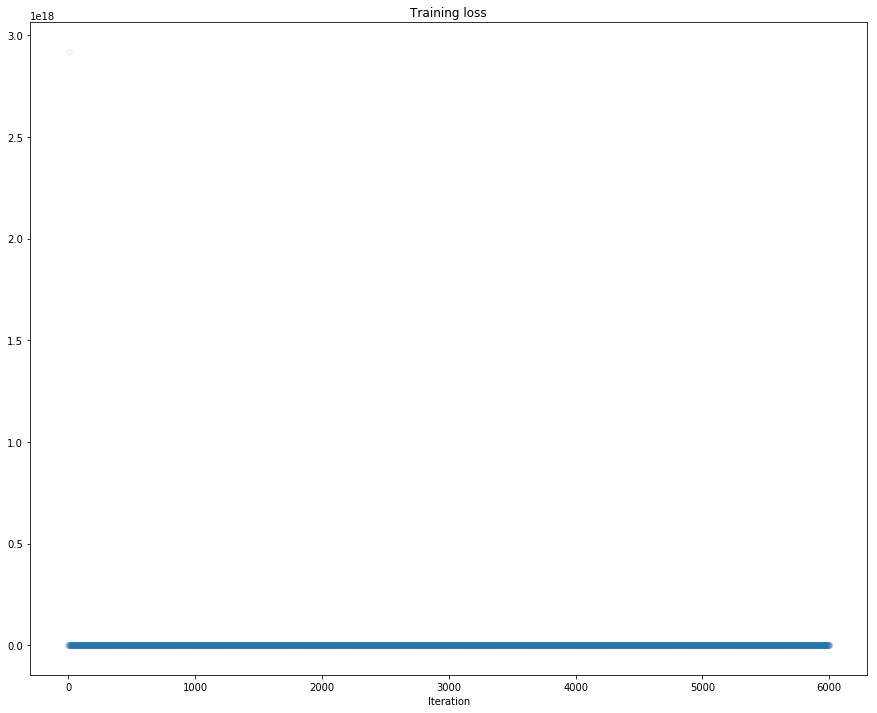

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=(7,7), stride=1, padding=1)
#         self.conv1_drop = nn.Dropout2d(p=0.5)

        self.conv2 = nn.Conv2d(8, 8, kernel_size=(3,3), stride=1, padding=1)
#         self.conv2_drop = nn.Dropout2d(p=0.5)

        self.conv3 = nn.Conv2d(8, 4, kernel_size=(1,1), stride=1, padding=1)
#         self.conv3_drop = nn.Dropout2d(p=0.5)

        self.bn1 = nn.BatchNorm2d(num_features=8)
        self.bn2 = nn.BatchNorm2d(num_features=8)
        self.bn3 = nn.BatchNorm2d(num_features=4)

        self.pool = nn.MaxPool2d(2, stride=2)
        self.fc1 = nn.Linear(15876, 8320)
#         self.fc1_drop = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(8320, 4160)
#         self.fc2_drop = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(4160, 42)
    
    def forward(self, x):
        p = True
        if p: print("input",x.size())
        x = self.conv1(x)
        if p: print("conv1",x.size())
#         x = self.bn1(x)
        x = F.relu(x, inplace=True)
        x = self.bn1(x)
        if p: print("bn1",x.size())
        
        x = self.conv2(x)
        if p: print("conv2",x.size())
#         x = self.bn2(x)
        x = F.relu(x, inplace=True)
        x = self.bn2(x)
        if p: print("bn2",x.size())
        
        x = self.conv3(x)
        if p: print("conv3",x.size())
#         x = self.bn3(x)
        x = F.relu(x, inplace=True)
        x = self.bn3(x)
        if p: print("bn3",x.size())
        
        x = self.pool(x)
        if p: print("pool",x.size())
        
        N, C, H, W = x.size() 
        x =  x.view(N, -1)
        
        if p: print("Flattened",x.size())

        x = self.fc1(x)
        x = F.relu(x)
#         x = self.fc1_drop(x)

        x = self.fc2(x)
        x = F.relu(x)
#         x = self.fc2_drop(x)

        x = self.fc3(x)
        x = F.relu(x)

        return x
    
torch.cuda.empty_cache()

train_data = HandGestureDataset("Dataset/", names, transform=False)
train_dataloader = torch.utils.data.DataLoader(data, batch_size=5, shuffle=True, num_workers=6)

gpu_dtype = torch.cuda.FloatTensor

print_every = 10

model = Net().type(gpu_dtype)

loss_fn = nn.MSELoss().type(gpu_dtype)
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, nesterov=True, weight_decay=0.0)

train(model, loss_fn, optimizer, train_dataloader, num_epochs=3)
# check_accuracy(model, loader_test)